In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, model_from_json
from keras.layers import Input, Dense, LSTM, Dropout, GaussianNoise
import math as m
# import script

Using TensorFlow backend.


In [2]:
companies = ['ABMD', 'ALK', 'AMGN', 'AXGN', 'BAX', 'BIO', 'BSTC', 'NHC', 'PDLI', 'TGTX', 'UTMD']
# files = ['','']

data_options = 1;

if data_options == 1:
    data_pd = pd.read_excel('healthcare_data_new.xls', sheet_name='ABMD')
elif data_options == 2:
    data_pd = pd.read_csv('stock_market_data-AAL.csv')
else:
    data_pd = pd.read_csv('hpq.us.txt',delimiter=',',usecols=['Date','Open','High','Low','Close'])
    data_pd.sort_values('Date')
    
#'''
print(data_pd.head())
print(data_pd.size)
print(data_pd.shape)
#'''

  Unnamed: 0  Operating Income (Loss)  Research & Development   Revenue  \
0 2014-01-22                  1398000                -7721000  44345000   
1 2014-01-23                  1398000                -7721000  44345000   
2 2014-01-24                  1398000                -7721000  44345000   
3 2014-01-27                  1398000                -7721000  44345000   
4 2014-01-28                  1398000                -7721000  44345000   

   Gross Profit  Net Income  TAL report  Stock price  Volume  Price variance  \
0      35318000     1059000          75    27.570000  197100     2867.245360   
1      35318000     1059000          76    27.250000  256400     5351.804994   
2      35318000     1059000          77    26.420000  346400     7649.377719   
3      35318000     1059000          80    26.549999  300600     9733.597103   
4      35318000     1059000          81    26.559999  321800    11604.702862   

        ROE      ROA  Net gearing  Current ratio       P/B         P

   Stock price
0    27.570000
1    27.250000
2    26.420000
3    26.549999
4    26.559999
1304
(1304, 1)


<function matplotlib.pyplot.show(*args, **kw)>

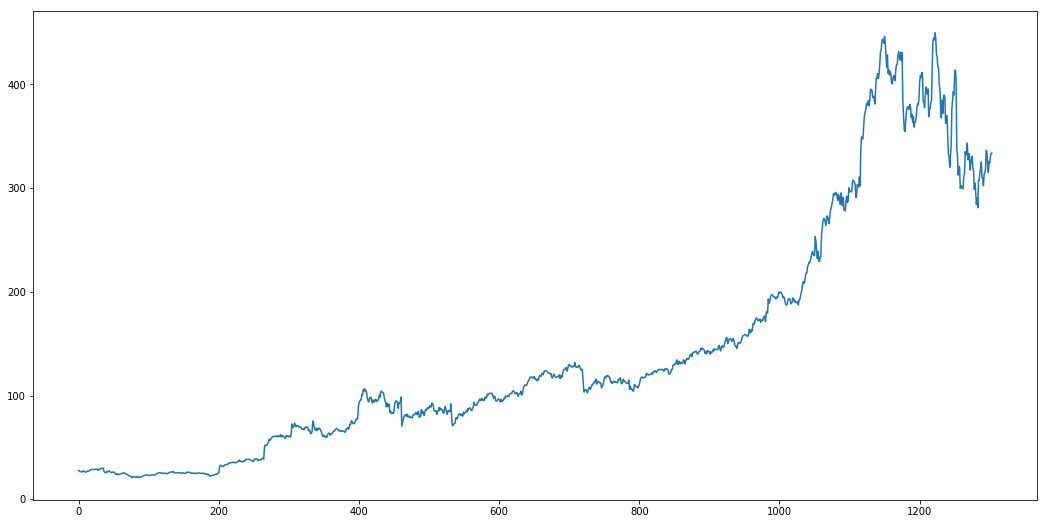

In [3]:
if data_options == 1:
    # cols = ['Volume', 'P/B', 'P/E', 'EvEBIT', 'Stock price']
    cols = ['Stock price']
    data_pd = data_pd.loc[:, cols]
    
#'''
print(data_pd.head())
print(data_pd.size)
print(data_pd.shape)
#'''

plt.figure(figsize = (18,9))
plt.plot(data_pd.values[:])
plt.show

In [ ]:
'''
def split_data_for_single_company(company_data, number_of_samples=4, number_of_training_tests=1, in_to_out_ratio=3):
    total_entries = company_data.shape[0]
    if number_of_training_tests > number_of_samples:
        number_of_training_tests = max(1, number_of_samples - 1)
    number_of_validation_tests = number_of_samples - number_of_training_tests
    in_to_all_ratio = in_to_out_ratio / (in_to_out_ratio + 1)

    # we assume that it - rows in sample - would be an integer, since our samples have to be of equal size
    number_of_rows_in_sample = int( total_entries / number_of_samples )
    number_of_in_rows = int( number_of_rows_in_sample * in_to_all_ratio )
    number_of_out_rows = number_of_rows_in_sample - number_of_in_rows
    # print(number_of_rows_in_sample)
    # print(number_of_in_rows)
    # print(number_of_out_rows)

    train_inp = []
    train_out = []
    validate_inp = []
    validate_out = []

    for i in range(number_of_training_tests):
        low_index = i * number_of_rows_in_sample
        mid_index = low_index + number_of_in_rows # separates input and output
        top_index = low_index + number_of_rows_in_sample
        train_inp.append(np.matrix(company_data[low_index : mid_index]))
        train_out.append(np.matrix(company_data[mid_index : top_index]))

    for i in range(number_of_validation_tests):
        low_index = (i + number_of_training_tests) * number_of_rows_in_sample
        mid_index = low_index + number_of_in_rows # separates input and output
        top_index = low_index + number_of_rows_in_sample
        validate_inp.append(np.matrix(company_data[low_index : mid_index]))
        validate_out.append(np.matrix(company_data[mid_index : top_index]))

    return train_inp, train_out, validate_inp, validate_out
'''

In [3]:
time_skip = 30
input_period_length = 90
output_period_length = 1
base_train_to_all_ratio = 0.8

def make_train_test_sets(data, skip=time_skip, in_len=input_period_length, out_len=output_period_length, train_to_total_ratio = base_train_to_all_ratio):
    total_sample_len = skip + in_len + out_len
    # dsize = data.shape[0]
    dsize = len(data)
    all_points = dsize - out_len - skip - in_len + 1
    train_points = m.floor(all_points * train_to_total_ratio)
    test_points = all_points - train_points
    train_data_in = []
    train_data_out = []
    test_data_in = []
    test_data_out = []
    
    for i in range(train_points):
        tmp_i = []
        tmp_o = []
        for j in range(in_len):
            tmp_i.append(data.values[i+j])
        for j in range(out_len):
            tmp_o.append(data.values[i+in_len+skip+j])
        train_data_in.append(tmp_i)
        train_data_out.append(tmp_o)
    
    for i in range(test_points):
        tmp_i = []
        tmp_o = []
        for j in range(in_len):
            tmp_i.append(data.values[train_points+i+j])
        for j in range(out_len):
            tmp_o.append(data.values[train_points+i+in_len+skip+j])
        test_data_in.append(tmp_i)
        test_data_out.append(tmp_o)
        
    np_trn_dat_in = np.array([x for x in train_data_in])
    np_trn_dat_out = np.array([x for x in train_data_out])
    np_tst_dat_in = np.array([x for x in test_data_in])
    np_tst_dat_out = np.array([x for x in test_data_out])
    
    # return train_data_in, train_data_out, test_data_in, test_data_out
    return np_trn_dat_in, np_trn_dat_out, np_tst_dat_in, np_tst_dat_out 


# train_i, train_o, test_i, test_o = make_train_test_sets(data_pd)

'''
print(train_i.shape)
print(train_o.shape)
print(test_i.shape)
print(test_o.shape)
tmp = np.concatenate( (np.array(train_i[:,0,0]), np.array(test_i[:,0,0])) )
print(tmp.shape)

plt.figure(figsize = (18,9))
plt.plot(train_i[:,0,0])
plt.show

plt.figure(figsize = (18,9))
plt.plot(test_i[:,0,0])
plt.show

plt.figure(figsize = (18,9))
plt.plot(tmp[:])
plt.show
# '''

'\nprint(train_i.shape)\nprint(train_o.shape)\nprint(test_i.shape)\nprint(test_o.shape)\ntmp = np.concatenate( (np.array(train_i[:,0,0]), np.array(test_i[:,0,0])) )\nprint(tmp.shape)\n\nplt.figure(figsize = (18,9))\nplt.plot(train_i[:,0,0])\nplt.show\n\nplt.figure(figsize = (18,9))\nplt.plot(test_i[:,0,0])\nplt.show\n\nplt.figure(figsize = (18,9))\nplt.plot(tmp[:])\nplt.show\n# '

In [ ]:
# Data scaling (optional)
'''
min_val = 0
max_val = 1

def scale_data(data, minv = min_val, maxv = max_val):
    return 0

#'''

In [4]:
# Defining lstm structure
batch_size = 1
epoch_num = 1
lstm_neurons = 100

def fit_lstm_i(train_train, train_validate, batch_s=batch_size, epochs=epoch_num, neurons=lstm_neurons):
    x = train_train
    y = train_validate
    
    model = Sequential()
    model.add(Input(shape=(x.shape[0],)))
    # model.add(LSTM(neurons, activation='tanh', inner_activation='hard_sigmoid', input_shape=(x.shape[1], x.shape[2]), return_sequences=True))
    model.add(LSTM(neurons, activation='tanh', inner_activation='hard_sigmoid', return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(100, activation='tanh', inner_activation='hard_sigmoid', return_sequences=True))
    # model.add(GaussianNoise(0.1))
    model.add(Dropout(0.2))
    model.add(Dense(output_dim=1, activation='linear'))

    model.compile(loss="mean_squared_error", optimizer="adam")
    model.fit(x, y, batch_size=batch_s, nb_epoch=epochs, shuffle=False)

    # save model
    model_json = model.to_json()
    with open("lstm_i.json", "w") as json_file: 
        json_file.write(model_json)
    model.save_weights("lstm_i.h5")

    return model

In [5]:
def forecast_lstm(model, batch_size, data):
    data = data.reshape(batch_size, len(data), data.shape[1])
    y_pred: object = model.predict(data, batch_size=batch_size)
    print(type(y_pred))
    return y_pred[0, 0]

In [ ]:
def plot_predictions(predictions, tst_validate):
    plt.plot(tst_validate, color='red', label='Actual Stock Prices')
    plt.plot(predictions, color='green', label='Predicted Stock Prices')
    plt.title('Stock Prices Historical Data')
    plt.xlabel('Time (Days)')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
    

def experiment(series):
    
    # transform data to be supervised learning
    tr_inp, tr_val, tst_inp, tst_val = make_train_test_sets(series)

    # transform the scale of the data
    
    # fit the base model
    lstm_model = fit_lstm_i(tr_inp, tr_val)

    # load model
    # '''
    # with open('lstm2.json', 'r') as json_file:
    #   loaded_model_json = json_file.read()
    #   lstm_model = model_from_json(loaded_model_json)
    #    # load weights into new model
    #   lstm_model.load_weights("lstm2.h5")
    # '''

    # forecast test dataset
    predictions = []
    for i in range(len(tst_inp)):
        # predict
        tmp_inp = tst_inp[i,:]
        tmp_prediction = forecast_lstm(lstm_model, 1, tmp_inp)
        
        # invert scaling
        
        print(tmp_prediction)
        
        # store forecast
        predictions.append(tmp_prediction)
    # report performance
    rmse = m.sqrt(mean_squared_error(tst_val, predictions))
    print(rmse)
    plot_predictions(predictions, tst_val)
    # return rmse, predictions

experiment(data_pd)